## 实验介绍

### 1.实验内容

本实验包括: 
* 深入理解半监督学习的概念，掌握常用半监督学习算法。
* 利用半监督学习算法，实现手写体字符的图像分类。

### 2.实验环境

* python 3.6.5
* numpy 1.13.3
* pandas 0.23.4 
* scikit-image 0.14.2    
* scikit-learn 0.20.2
* Pillow 5.4.1              
* tensorflow 1.12.0
* torch 1.0.0     
* torchvision 0.2.1

### 3.数据介绍

实验数据集由mnist数据集中的部分图片组成。数据集分为训练集和测试集，分别存放在Train和Test文件夹中。在Train文件夹中，labelled文件夹中存放的是有标签信息的图片，每类10张共100张；unlabelled文件夹中存放的是900张没有标签信息的图片。在Test文件夹中，存放了10000张有标签信息的图片，供大家验证自己所使用的半监督学习的效果。

### 4.实验准备

点击屏幕右上方的下载实验数据模块，选择下载SSL_dataset.tgz到指定目录下，然后再依次选择点击上方的File->Open->Upload,上传刚才下载的数据集压缩包，再使用如下命令解压：

In [1]:
# !tar -zxvf ./work/SSL_mnist.tgz -C ./dataset/

### 5. 使用S3VM算法

In [2]:
import os
import numpy as np
from sklearn.svm import SVC
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
# 加载标记数据和未标记数据
labeled_data = []
unlabeled_data = []

In [4]:
for i in range(10):
    for filename in os.listdir("./dataset/SSL_mnist/Train/labelled/" + str(i)):
        img = np.array(Image.open("./dataset/SSL_mnist/Train/labelled/" + str(i) + "/" + filename).convert('L')).reshape(-1)
        labeled_data.append((img, i))
    for filename in os.listdir("./dataset/SSL_mnist/Train/unlabelled"):
        img = np.array(Image.open("./dataset/SSL_mnist/Train/unlabelled/" + filename).convert('L')).reshape(-1)
        unlabeled_data.append(img)

In [13]:
# 创建S3VM分类器
svm = SVC(kernel='rbf')
classifier = SelfTrainingClassifier(svm)

In [14]:
# 使用标记数据进行有监督训练
X_labeled = [data[0] for data in labeled_data]
y_labeled = [data[1] for data in labeled_data]
classifier.fit(X_labeled, y_labeled)

d:\newprogramfile\python\lib\site-packages\sklearn\semi_supervised\_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


SelfTrainingClassifier(base_estimator=SVC())

In [15]:
# 对未标记数据进行分类
X_unlabeled = np.array(unlabeled_data)
y_pred = classifier.predict(X_unlabeled)

In [16]:
# 加载测试数据集
test_data = []
for i in range(10):
    for filename in os.listdir("./dataset/SSL_mnist/Test/" + str(i)):
        img = np.array(Image.open("./dataset/SSL_mnist/Test/" + str(i) + "/" + filename).convert('L')).reshape(-1)
        test_data.append((img, i))

In [17]:
# 对测试数据进行预测
X_test = [data[0] for data in test_data]
y_true = [data[1] for data in test_data]
y_pred_test = classifier.predict(X_test)

In [18]:
# 评估分类器的性能
print("Confusion matrix:")
# 计算混淆矩阵
conf_mat = confusion_matrix(y_true, y_pred_test)
print(conf_mat)
print("Accuracy:", accuracy_score(y_true, y_pred_test))
print("Recall:", recall_score(y_true, y_pred_test, average='macro'))

Confusion matrix:
[[ 796    0    1   11    0  150   19    1    2    0]
 [   0 1075    1   26    0   14    2    0   17    0]
 [  11   24  791   26   20   83   12    8   56    1]
 [   3    1   18  841    2  102    1    9   28    5]
 [   0   11    3    2  812   55   11    0   16   72]
 [   5   10    0  265    9  450   23    2  118   10]
 [   2   11    4   25   21   77  806    2   10    0]
 [   2   60   27    3   25   32    0  757   48   74]
 [  12   13    7   89   12  130    4    6  694    7]
 [  13   13    5   19  198   64    5   44   57  591]]
Accuracy: 0.7613
Recall: 0.7565867363921844


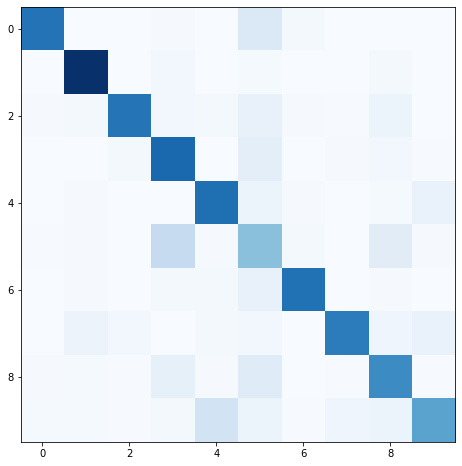

In [19]:
# 绘制混淆矩阵图
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(conf_mat, cmap='Blues')

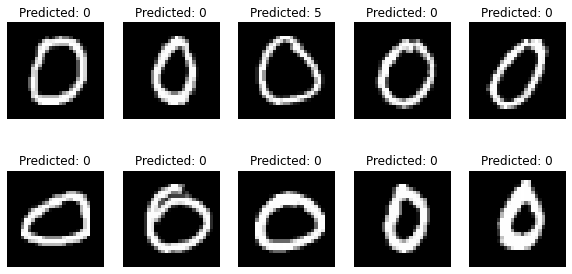

In [20]:
# 显示一些测试图像及其预测结果
X_test_reshaped = np.array(X_test).reshape(-1, 28, 28)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(X_test_reshaped[i], cmap='gray')
    ax.set(title=f"Predicted: {y_pred_test[i]}")
    ax.axis('off')

### 6. 使用K-means实现

In [1]:
import os
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score
import matplotlib.pyplot as plt

In [2]:
# 加载标记数据和未标记数据
labeled_data = []
unlabeled_data = []
for i in range(10):
    for filename in os.listdir("./dataset/SSL_mnist/Train/labelled/" + str(i)):
        img = np.array(Image.open("./dataset/SSL_mnist/Train/labelled/" + str(i) + "/" + filename).convert('L'))
        labeled_data.append((img, i))
    for filename in os.listdir("./dataset/SSL_mnist/Train/unlabelled"):
        img = np.array(Image.open("./dataset/SSL_mnist/Train/unlabelled/" + filename).convert('L'))
        unlabeled_data.append(img)

In [3]:
# 将图像转换为一维数组
X_labeled = [data[0].reshape(-1) for data in labeled_data]
y_labeled = [data[1] for data in labeled_data]
X_unlabeled = [img.reshape(-1) for img in unlabeled_data]


In [4]:
# 使用标记数据进行有监督训练
classifier = KMeans(n_clusters=10, random_state=42)
classifier.fit(X_labeled)

KMeans(n_clusters=10, random_state=42)

In [5]:
# 对未标记数据进行聚类并分配类别
y_unlabeled = classifier.predict(X_unlabeled)

In [6]:
# 根据最近邻原则将每个簇分配给最接近其质心的标记类别
centroids = classifier.cluster_centers_
y_pred = []
for i in range(len(unlabeled_data)):
    distances = np.linalg.norm(centroids - X_unlabeled[i], axis=1)
    closest_cluster = np.argmin(distances)
    y_pred.append(y_labeled[closest_cluster])

In [7]:
# 加载测试数据集
test_data = []
for i in range(10):
    for filename in os.listdir("./dataset/SSL_mnist/Test/" + str(i)):
        img = np.array(Image.open("./dataset/SSL_mnist/Test/" + str(i) + "/" + filename).convert('L'))
        test_data.append((img, i))

In [8]:
# 对测试数据进行预测并计算准确率
X_test = [data[0].reshape(-1) for data in test_data]
y_true = [data[1] for data in test_data]
y_pred_test = []

In [9]:
for i in range(len(X_test)):
    distances = np.linalg.norm(centroids - X_test[i], axis=1)
    closest_cluster = np.argmin(distances)
    y_pred_test.append(y_labeled[closest_cluster])

In [10]:
accuracy = accuracy_score(y_true, y_pred_test)
print("Test accuracy:", accuracy)

Test accuracy: 0.098


In [11]:
# 评估分类器的性能
print("Confusion matrix:")
# 计算混淆矩阵
conf_mat = confusion_matrix(y_true, y_pred_test)
print(conf_mat)
print("Accuracy:", accuracy_score(y_true, y_pred_test))
print("Recall:", recall_score(y_true, y_pred_test, average='macro'))

Confusion matrix:
[[ 980    0    0    0    0    0    0    0    0    0]
 [1135    0    0    0    0    0    0    0    0    0]
 [1032    0    0    0    0    0    0    0    0    0]
 [1010    0    0    0    0    0    0    0    0    0]
 [ 982    0    0    0    0    0    0    0    0    0]
 [ 892    0    0    0    0    0    0    0    0    0]
 [ 958    0    0    0    0    0    0    0    0    0]
 [1028    0    0    0    0    0    0    0    0    0]
 [ 974    0    0    0    0    0    0    0    0    0]
 [1009    0    0    0    0    0    0    0    0    0]]
Accuracy: 0.098
Recall: 0.1


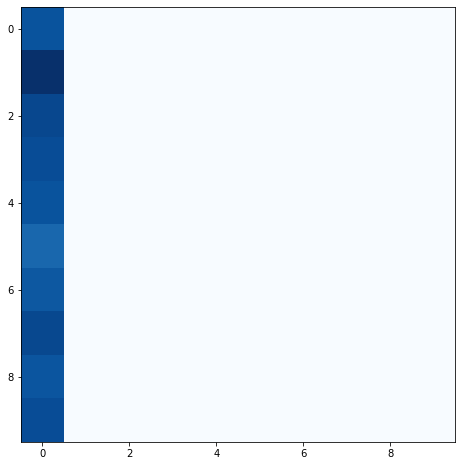

In [12]:
# 绘制混淆矩阵图
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(conf_mat, cmap='Blues')

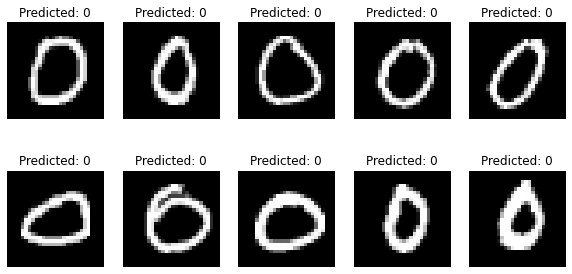

In [13]:
# 显示一些测试图像及其预测结果
X_test_reshaped = np.array(X_test).reshape(-1, 28, 28)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(X_test_reshaped[i], cmap='gray')
    ax.set(title=f"Predicted: {y_pred_test[i]}")
    ax.axis('off')

> 使用S3VM进行半监督学习具有比较好的效果